# SOMTEST

Testing the different Python implementations of Kohonen's Self-Organizing Maps.

## Criteria

- Inputs:
    - `numpy` array?
    - `pandas` dataframe?
    - native Python list of lists?
- Outputs:
    - UMatrix
    - Hits Map
    - Clustering
    - Weights matrix
- Parameters:
    - topology type: rectangular; ring; etc
    - grid type: square; hexagonal
    - number of epochs
    - initialization
- Utility:
    - BMU finder
    - Visualizations
        - UMatrix
        - Hits Map
- Last GitHub update        
        
Notes:

Could not install [somoclu](https://github.com/peterwittek/somoclu).

## Setup

### Load packages

In [1]:
import json
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

import warnings
warnings.filterwarnings('ignore')

# https://stackoverflow.com/questions/56618739/matplotlib-throws-warning-message-because-of-findfont-python
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# importing sompy enables more logging
logging.disable(logging.INFO)

In [2]:

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
import seaborn as sns

%matplotlib inline

sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 50

### Load dataset

In [3]:
from sklearn.datasets import load_iris, load_wine
dataset = load_wine()


In [4]:
feats = dataset.feature_names
target = dataset.target
target_names = dataset.target_names

df_orig = pd.DataFrame(dataset.data, columns=feats)
df_orig['target'] = target

scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_orig[feats])
df = pd.DataFrame(scaler.transform(df_orig[feats]), columns=feats)
df['target'] = df_orig['target']

#df

### Set global vars


In [5]:

N_ITERS = 5000
N_TRAIN = 50

N_JOBS = 5

M = 15         # matrix size
N = 10          # matrix size
P = len(feats) # number of inputs

K = 3 # number of clusters

NEIGHBOURHOOD = 'gaussian'
DISTANCE = 'euclidean'

f1_ave = 'macro'
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)


### Utility functions for visualization 

In [6]:
## UMATRIX

def plot_umatrix(xx, yy, weights, umatrix, title="UMatrix", cmap=cm.viridis):
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)

    ax.set_aspect('equal')

    # iteratively add hexagons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=.95 / np.sqrt(3),
                                 facecolor=cmap(umatrix[i, j]), 
                                 alpha=1, 
                                 #edgecolor='gray'
                                )
            ax.add_patch(hexagon)


    ax.margins(.05)
    ax.axis("off")

    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="2%", pad=0)    
    cb1 = colorbar.ColorbarBase(ax_cb, cmap=cmap, 
                                orientation='vertical', alpha=.4)
    cb1.ax.get_yaxis().labelpad = 16
    cb1.ax.set_ylabel('distance from neighbouring neurons',
                      rotation=270, fontsize=12)
    plt.gcf().add_axes(ax_cb)

    plt.show()

In [7]:
## HITSMATRIX

def plot_hits(xx, yy, hitsmatrix, title="Hits"):

    maxhits = hitsmatrix.max()
    fig, ax = plt.subplots(1,1,figsize=(10,10))

    ax.set_aspect('equal')

    # iteratively add hexagons
    for i in range(hitsmatrix.shape[0]):
        for j in range(hitsmatrix.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=.95 / np.sqrt(3),
                                 facecolor=cm.Blues(hitsmatrix[i, j]/maxhits), 
                                 alpha=1, 
                                )
            ax.add_patch(hexagon)
            ax.text(xx[(i, j)], wy, int(hitsmatrix[i, j]), ha='center', va='center', fontsize=8)


    ax.margins(.05)
    ax.axis("off")

    plt.title(title)

    divider = make_axes_locatable(ax)

    cax = divider.append_axes("right", size='5%', pad=0)

    im = plt.imshow(hitsmatrix, cmap=cm.Blues, origin='lower', aspect=9)
    plt.colorbar(im, cax=cax)

    plt.show()

In [8]:
## HITSMATRIX

def plot_hits_rect(hitsmatrix, title="Hits"):

    maxhits = hitsmatrix.max()
    fig, ax = plt.subplots(1,1,figsize=(10,10))

    ax.set_aspect('equal')

    # iteratively add hexagons
    
    ax.imshow(hitsmatrix)
    ax.margins(.05)
    ax.axis("off")

    plt.title(title)

    divider = make_axes_locatable(ax)

    cax = divider.append_axes("right", size='5%', pad=0)

    im = plt.imshow(hitsmatrix, cmap=cm.Blues, origin='lower', aspect=9)
    plt.colorbar(im, cax=cax)

    plt.show()

In [9]:
## CLUSTERS
def plot_clusters(xx, yy, clusmatrix, k, title="Clusters"):
    colors = [plt.cm.Set2(i) for i in range(k)]

    fig, ax = plt.subplots(1,1,figsize=(10,10))

    ax.set_aspect('equal')

    # iteratively add hexagons
    for i in range(clusmatrix.shape[0]):
        for j in range(clusmatrix.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=1 / np.sqrt(3),
                                 facecolor=colors[clusmatrix[i][j]], 
                                 alpha=.5, 
                                )
            ax.add_patch(hexagon)
            ax.text(xx[(i, j)], wy, clusmatrix[i][j], ha='center', va='center', fontsize=8)


    ax.margins(.05)
    ax.axis("off")

    plt.title(title)

    plt.show()

## Tests

### SOMPY

Source: https://github.com/sevamoo/SOMPY

Stars: 490 

Last update: 10 APR 2022

In [10]:
import sompy
from sompy.visualization.mapview import View2D as sompy_View2D
from sompy.visualization.bmuhits import BmuHitsView as sompy_BmuHitsView
from sompy.visualization.hitmap import HitMapView as HitMapView


#### Train

In [11]:
sompy_model = sompy.SOMFactory().build(
    df[feats].values, 
    mapsize=[N,M],
    initialization='random', 
    neighborhood=NEIGHBOURHOOD,
    training='batch',
    lattice='hexa',
    component_names=feats
)
sompy_model.train(n_job=N_JOBS, train_rough_len=N_TRAIN, train_finetune_len=N_TRAIN)

print('done')

done


#### Visualize UMatrix

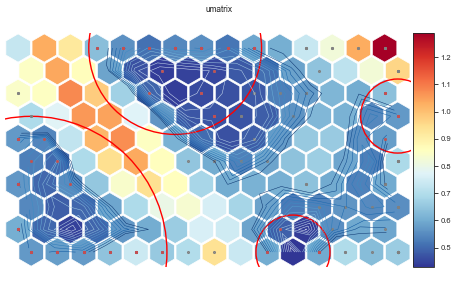

In [12]:
u = sompy.umatrix.UMatrixView(M, N, 'umatrix', show_axis=True)

UMAT = u.show(
    sompy_model, 
    distance=2,
    row_normalized=False,
    show_data=True, 
    contour=True,
    blob=True
)


#### Visualize Hits

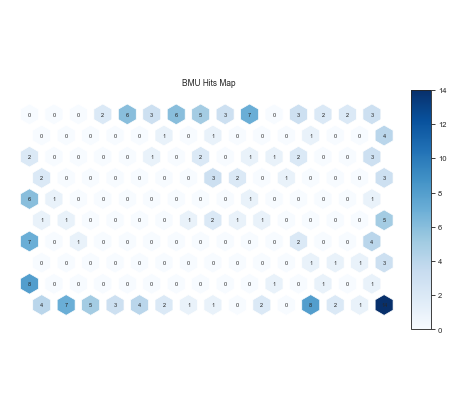

In [13]:
sompy_vhts  = sompy_BmuHitsView(11,11,"")
sompy_vhts.show(sompy_model, anotate=True, onlyzeros=False, labelsize=8, cmap="Blues")
plt.title("BMU Hits Map", x=-10, y=1)
plt.show()

#### Visualize Clusters

In [14]:
sompy_codebook = sompy_model.codebook.matrix
sompy_kmeans = KMeans(n_clusters=K, init='k-means++', n_init=20, random_state=RANDOM_STATE)
sompy_labels = sompy_kmeans.fit_predict(sompy_codebook)
sompy_model.cluster_labels = sompy_labels  


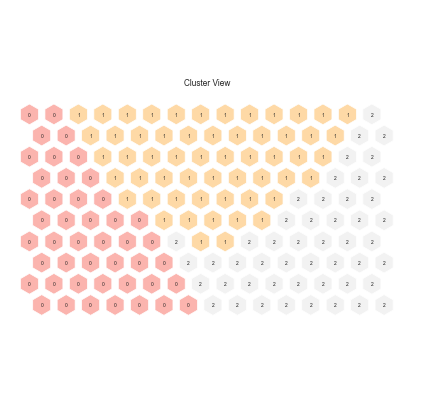

In [15]:

sompy_hits = HitMapView(11, 11,"", text_size=10)
sompy_hits.show(sompy_model, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")
plt.title("Cluster View", x=0.5, y=1)

plt.show()

In [16]:
def cluster_sompy(sm, k, df_, som_vars):
    df = df_.copy()
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, random_state=RANDOM_STATE)
    nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
    sm.cluster_labels = nodeclus_labels  

    # Check the nodes and and respective clusters
    nodes = sm.codebook.matrix

    somlabelk = 'som_label_'+str(k)

    df_nodes = pd.DataFrame(nodes, columns=som_vars)
    df_nodes[somlabelk] = nodeclus_labels

    # Obtaining SOM's BMUs labels
    bmus_map = sm.find_bmu(df[som_vars])[0]  # get bmus for each observation in df
    bmuk = 'BMU'+str(k)
    df[bmuk] = bmus_map
    df_bmus = df.copy()

    # Get cluster labels for each observation
    df = df_bmus.merge(df_nodes[somlabelk], 'left', left_on=bmuk, right_index=True)

    
    return df[somlabelk]


In [17]:
cluster_sompy_labels = cluster_sompy(sompy_model,K, df, feats)


#### Evaluate

In [18]:
print('Homogeneity: ', np.round(homogeneity_score(df.target, cluster_sompy_labels),5))
print('Completeness:', np.round(completeness_score(df.target, cluster_sompy_labels),5))
print('V Measure:   ', np.round(v_measure_score(df.target, cluster_sompy_labels),5))


Homogeneity:  0.10376
Completeness: 0.40907
V Measure:    0.16553


#### Comments

- Inputs:
    - `numpy` array
- Outputs:
    - UMatrix
    - Hits Map
    - Clustering
    - Weights matrix
- Parameters:
    - topology type: rectangular
    - lattice type: square; hexagonal
    - number of epochs
    - initialization
- Utility:
    - BMU finder
    - Visualizations
        - UMatrix
        - Hits Map
- Last GitHub update:
    - April 2022


Documentation is sparse. 

Has utility functions for visualization, but difficult to configure.



### MiniSOM

Source: https://github.com/JustGlowing/minisom/

Stars: 1100+

Last updated: 28 Sep 2022


In [19]:
from minisom import MiniSom

#### Train

In [20]:
minisom_model = MiniSom(M, N, P, 
              sigma=1.5, learning_rate=.7, 
              activation_distance=DISTANCE,
              topology='hexagonal', 
              neighborhood_function=NEIGHBOURHOOD, 
              random_seed=RANDOM_STATE
             ) # initialization of SOM


In [21]:
minisom_model.train_batch(df[feats].values, N_ITERS, verbose=True)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.18934422606945078


In [22]:
## generates equivalent rectangular coordinates for hex lattice
minisom_xx, minisom_yy  = minisom_model.get_euclidean_coordinates()


#### Visualize UMatrix

In [23]:
minisom_umatrix = minisom_model.distance_map()
minisom_weights = minisom_model.get_weights()


In [24]:
print(minisom_umatrix.shape)
print(minisom_weights.shape)

(15, 10)
(15, 10, 13)


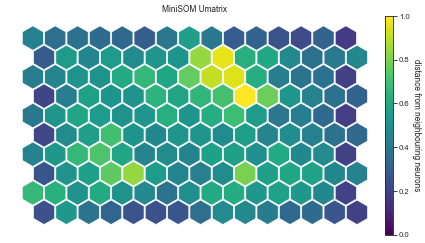

In [25]:
plot_umatrix(minisom_xx, minisom_yy, minisom_weights, minisom_umatrix, "MiniSOM Umatrix")

#### Visualize Hits

In [26]:
## Count how many data points have this neuron as BMU
minisom_hitsmatrix = np.zeros((M,N))

for rownum, rowdata in enumerate(df[feats].values):
    wx, wy = minisom_model.winner(rowdata)
    minisom_hitsmatrix[wx][wy] += 1

#print(minisom_hitsmatrix)
#print(minisom_hitsmatrix.shape)
#print(minisom_hitsmatrix.max())

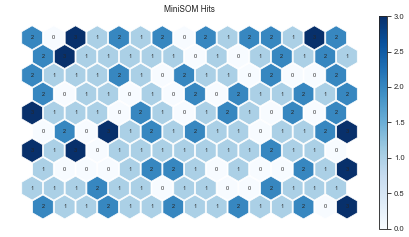

In [27]:
plot_hits(minisom_xx, minisom_yy, minisom_hitsmatrix, "MiniSOM Hits")

#### Visualize Clusters

In [28]:

minisom_weights_flat = minisom_weights.reshape((M*N),minisom_weights.shape[-1])
minisom_weights_flat.shape

(150, 13)

In [29]:
# Perform K-Means clustering with selected K

minisom_kmeans = KMeans(n_clusters=K, n_init=20, random_state=RANDOM_STATE)
minisom_cluster_labels = minisom_kmeans.fit_predict(minisom_weights_flat)

# Each neuron's cluster label
minisom_cluster_labels 


array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [30]:
# get matrix coords of each data point's BMU
# winner_coordinates is of this shape:
# ( 2, len(data) )
# [ [x1, x2, ... xi] , [y1, y2, ... yi] ]

minisom_winner_coordinates = np.array([minisom_model.winner(x) for x in df[feats].values]).T

# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
minisom_bmu_index = np.ravel_multi_index(minisom_winner_coordinates, (M,N))

# Cluster label of each data point's BMU
minisom_labels = [minisom_cluster_labels[i] for i in minisom_bmu_index]

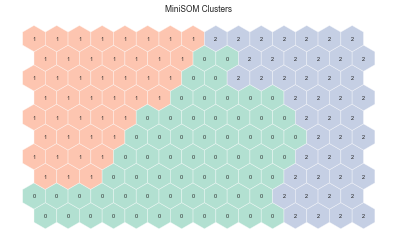

In [31]:
plot_clusters(minisom_xx, minisom_yy, minisom_cluster_labels.reshape(M,N), K, "MiniSOM Clusters")

#### Evaluate

In [32]:
minisom_cluster_labels.shape

(150,)

In [33]:
print('Homogeneity: ', np.round(homogeneity_score(df.target, minisom_labels),5))
print('Completeness:', np.round(completeness_score(df.target, minisom_labels),5))
print('V Measure:   ', np.round(v_measure_score(df.target, minisom_labels),5))


Homogeneity:  0.88802
Completeness: 0.88064
V Measure:    0.88432


#### Comments

- Inputs:
    - `numpy` array?
- Outputs:
    - UMatrix `.distance_map()`
    - Hits Map - can be calculated
    - Clustering - can be calculated
    - Weights matrix `.get_weights()`
- Parameters:
    - topology type: rectangular
    - lattice type: square; hexagonal
    - number of epochs
    - initialization
- Utility:
    - BMU finder
    - Visualizations
        - Not built in
- Last GitHub update 
    - Sep 2022

No built in visualizations. Good documentation of features.

Can be pickled!

### sklearn-som

Source: https://github.com/rileypsmith/sklearn-som

GitHub stars: 35

Last updated: 30 Jun 2021

In [34]:
from sklearn_som.som import SOM as sklearnsom


#### Train

In [35]:
sklearnsom_model = sklearnsom(m=M, n=N, dim=len(feats), 
                              random_state=RANDOM_STATE)
sklearnsom_model.fit(df[feats].values,
                     epochs=N_ITERS)

In [36]:
predictions = sklearnsom_model.predict(df[feats].values)


In [37]:
len(set(predictions))

97

In [38]:
## Get the index of the BMU for each data point
sklearnsom_winner_indexes = [sklearnsom._find_bmu(sklearnsom_model, x ) for x in df[feats].values]


#### Visualize UMatrix

Not straightforward to visualize UMatrix. No utility function to calculate neuron distances to each neighbour.

#### Visualize Hits

*Rethink visualization examples: may be rectangular lattice??*

In [39]:
## Count how many data points have this neuron as BMU
sklearnsom_hits_flat = np.array([0 for i in range(M*N)])

for rownum, rowdata in enumerate(df[feats].values):
    i = sklearnsom._find_bmu(sklearnsom_model, rowdata )
    sklearnsom_hits_flat[i] += 1

sklearnsom_hitsmatrix = sklearnsom_hits_flat.reshape((M,N))

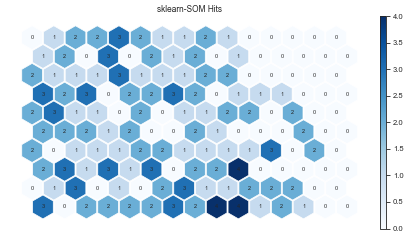

In [40]:
plot_hits(minisom_xx, minisom_yy, sklearnsom_hitsmatrix, "sklearn-SOM Hits")

#### Visualize Clusters

In [41]:
## Neuron weights
sklearnsom_weights = sklearnsom_model.weights
#print(sklearnsom_weights.shape)

# Perform K-Means clustering with selected K

sklearnsom_kmeans = KMeans(n_clusters=K, n_init=20, random_state=RANDOM_STATE)
sklearnsom_cluster_labels = sklearnsom_kmeans.fit_predict(sklearnsom_weights)

# Each neuron's cluster label
sklearnsom_cluster_labels


array([2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2,
       2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 0], dtype=int32)

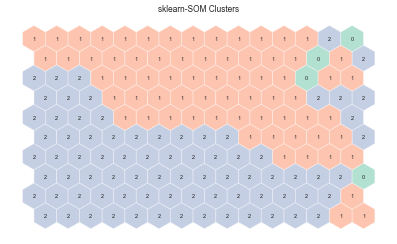

In [42]:
plot_clusters(minisom_xx, minisom_yy, sklearnsom_cluster_labels.reshape(M,N), K, "sklearn-SOM Clusters")

#### Evaluate

In [43]:
sklearnsom_labels = np.array([sklearnsom_cluster_labels[x] for x in sklearnsom_winner_indexes ])


In [44]:
print('Homogeneity: ', np.round(homogeneity_score(df.target, sklearnsom_labels),5))
print('Completeness:', np.round(completeness_score(df.target, sklearnsom_labels),5))
print('V Measure:   ', np.round(v_measure_score(df.target, sklearnsom_labels),5))


Homogeneity:  0.39647
Completeness: 0.65016
V Measure:    0.49257


#### Comments

- Inputs:
    - `numpy` array
- Outputs:
    - UMatrix - no neighbor distance matrix; instead has distances to cluster centroids
    - Hits Map - can be calculated
    - Clustering - can be calculated
    - Weights matrix - yes
- Parameters:
    - topology type: rectangular
    - lattice type: square
    - number of epochs
    - sigma
- Utility:
    - BMU finder
- Last GitHub update   
    - June 2021

### kohonen

Source: https://github.com/lmjohns3/kohonen

GitHub Stars: 69

Last Update: 4 Jun 2018

*Poor documentation*

In [45]:
from kohonen import kohonen


#### Train

In [46]:
kohonen_model = kohonen.Map

kohonen_model.shape = (M,N)
kohonen_model.dimension = len(feats)
kohonen_model.rng = RANDOM_STATE


#### Visualize

#### Visualize UMatrix

#### Visualize Hits

#### Visualize Clusters

#### Evaluate

#### Comments

- Last GitHub update
    - June 2018

### neupy

Source: https://github.com/itdxer/neupy

GitHub stars: 722

Last update: 2 Sep 2019

*Not compatible with python 3.10*


In [47]:
from platform import python_version
print(python_version())

3.10.6


In [48]:
#from neupy import algorithms as neupy_alg, utils as neupy_alg
#from collections.abc import Mapping, MutableMapping
#from neupy import algorithms, utils

#utils.reproducible()

#### Train

#### Visualize

#### Visualize UMatrix

#### Visualize Hits

#### Visualize Clusters

#### Evaluate

#### Comments

- Inputs:
    - `numpy` array?
    - `pandas` dataframe?
    - native Python list of lists?
- Outputs:
    - UMatrix
    - Hits Map
    - Clustering
    - Weights matrix
- Parameters:
    - topology type: rectangular; ring; etc
    - grid type: square; hexagonal
    - number of epochs
    - initialization
- Utility:
    - BMU finder
    - Visualizations
        - UMatrix
        - Hits Map
- Last GitHub update   

### simpsom

Source: https://github.com/fcomitani/SimpSOM

GitHub Stars: 123

Last update: 24 Oct 2022


In [49]:
import simpsom as simpsom

#### Train

In [50]:
simpsom_net = simpsom.network.SOMNet(N, M, df[feats].values, 
                                topology='hexagonal', # seems to be for v3.0+ only?
                                init='random', metric=DISTANCE,
                                neighborhood_fun=NEIGHBOURHOOD, # seems to be for v3.0+ only?
                                random_seed=RANDOM_STATE
                              )

simpsom_model = simpsom_net.train(train_algo='batch', start_learning_rate=0.01, epochs=N_ITERS, batch_size=-1)

2022-11-14 23:27:34.658 | INFO     | simpsom.network:__init__:107 - Hexagonal topology.
2022-11-14 23:27:34.659 | INFO     | simpsom.network:_set_weights:184 - The weights will be initialized randomly.
2022-11-14 23:27:34.662 | INFO     | simpsom.network:train:369 - The map will be trained with the batch algorithm.


In [51]:
simpsom_model

#### Visualize UMatrix

2022-11-14 23:27:42.779 | INFO     | simpsom.network:get_nodes_difference:576 - Weights difference among neighboring nodes calculated.


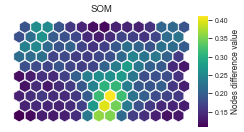

2022-11-14 23:27:42.970 | INFO     | simpsom.network:plot_map_by_difference:748 - Node difference map will be saved to:
././som_difference.png


In [52]:
simpsom_net.plot_map_by_difference(show=True)


#### Visualize Hits

In [53]:
## Count how many data points have this neuron as BMU
simpsom_hits_flat = np.array([0 for i in range(M*N)])

for rowdata in df[feats].values:
    i = simpsom_net.find_bmu_ix(np.array([rowdata]))[0]
    simpsom_hits_flat[i] += 1

simpsom_hitsmatrix = simpsom_hits_flat.reshape((M,N))


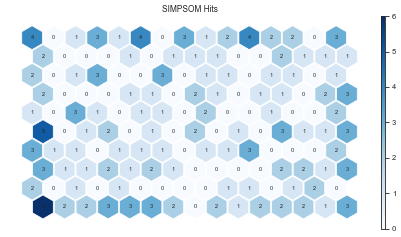

In [54]:
plot_hits(minisom_xx, minisom_yy, simpsom_hitsmatrix, "SIMPSOM Hits")

#### Visualize Clusters

In [55]:
simpsom_weights = [node.weights.tolist() for node in simpsom_net.nodes_list]



In [56]:
simpsom_kmeans = KMeans(n_clusters=K, n_init=20, random_state=RANDOM_STATE)
simpsom_cluster_labels = simpsom_kmeans.fit_predict(simpsom_weights)

# Each neuron's cluster label
simpsom_cluster_labels


array([2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

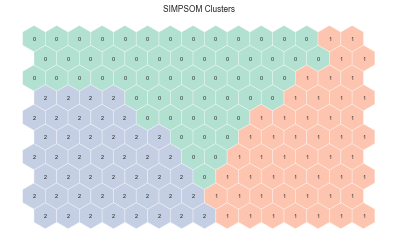

In [57]:
plot_clusters(minisom_xx, minisom_yy, simpsom_cluster_labels.reshape(M,N), K, "SIMPSOM Clusters")

#### Component Planes

In [58]:
dataset.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

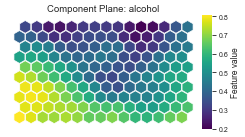

2022-11-14 23:27:43.585 | INFO     | simpsom.network:plot_map_by_feature:710 - Feature map will be saved to:
././som_feature_0.png


In [59]:
_ = simpsom_net.plot_map_by_feature(feature=0, show=True, print_out=True, title=f'Component Plane: {dataset.feature_names[0]}')


#### Evaluate

In [60]:
simpsom_labels = [simpsom_cluster_labels[simpsom_net.find_bmu_ix(d)] for d in np.array([df[feats].values])]
simpsom_labels = simpsom_labels[0]

In [61]:
simpsom_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 2,
       0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [62]:
print('Homogeneity: ', np.round(homogeneity_score(df.target, simpsom_labels),5))
print('Completeness:', np.round(completeness_score(df.target, simpsom_labels),5))
print('V Measure:   ', np.round(v_measure_score(df.target, simpsom_labels),5))


Homogeneity:  0.76425
Completeness: 0.75578
V Measure:    0.75999


#### Comments

- Inputs:
    - `numpy` array?
- Outputs:
    - UMatrix: `plot_map_by_difference`
    - Hits Map: manually constructed
    - Clustering: has built in clustering, but clusters data, not weights
    - Weights matrix: see Visualize Clusters
- Parameters:
    - topology type: rectangular; 
    - grid type: hexagonal
    - number of epochs
    - initialization
    - neighborhood
- Utility:
    - BMU finder
    - Visualizations: has own
        - UMatrix
        - Component planes

- Last GitHub update 
    - October 2022

### GEMA

Source: https://github.com/ufvceiec/GEMA

GitHub Stars: 13

Last update: 1 Jul 2022


In [63]:
import GEMA

#### Train

In [64]:
gema_model = GEMA.Map(df[feats].values, 
                    M, 
                    N_ITERS, 
                    initial_lr=0.1, 
                    initial_neighbourhood = 0,
                    distance = DISTANCE,
                    use_decay= False,
                    presentation= 'random',
                    weights = 'random')

TRAINING...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 22725.00it/s]

FINISHED.


#### Visualize

In [65]:
gema_classif = GEMA.Classification(gema_model, df[feats].values)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 3908.23it/s]


#### Visualize UMatrix

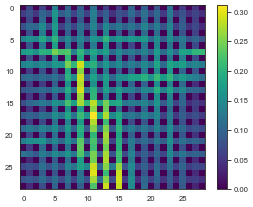

In [66]:
GEMA.Visualization.umatrix(gema_classif, colorscale="viridis")

In [67]:
gema_model.weights.shape

(15, 15, 13)

In [68]:
gema_model.calculate_bmu(df[feats].values[0])[1]

(14, 6)

#### Visualize Hits

In [69]:
## Count how many data points have this neuron as BMU
gema_hitsmatrix = np.zeros((M,M))

for rowdata in df[feats].values:
    wx, wy = gema_model.calculate_bmu(rowdata)[1]
    gema_hitsmatrix[wx][wy] += 1
#gema_hitsmatrix

In [70]:
gema_hitsmatrix_masked = gema_hitsmatrix.copy().astype(int).astype(str)

gema_hitsmatrix_masked[gema_hitsmatrix_masked == '0'] = ""


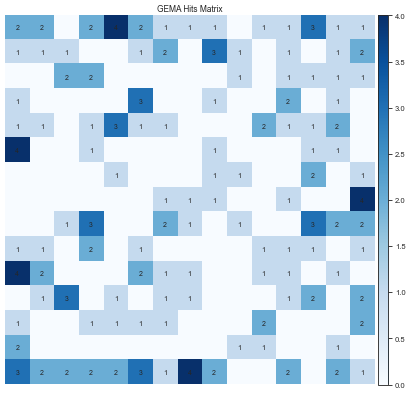

In [71]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.set_aspect('equal')

ax.imshow(gema_hitsmatrix, cmap='Blues')

for i in range(gema_hitsmatrix.shape[0]):
    for j in range(gema_hitsmatrix.shape[1]):
        ax.text(j, i, gema_hitsmatrix_masked[i,j], ha="center", va="center")
        
ax.margins(.05)
ax.axis("off")

plt.title("GEMA Hits Matrix")

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size='5%', pad=0)

im = plt.imshow(gema_hitsmatrix, cmap=cm.Blues, origin='lower', aspect=9)
plt.colorbar(im, cax=cax)

plt.show()

#### Visualize Clusters

In [72]:
gema_flat_weights = gema_model.weights.reshape((M*M, 13))

gema_kmeans = KMeans(n_clusters=K, n_init=20, random_state=RANDOM_STATE)
gema_cluster_labels_flat = gema_kmeans.fit_predict(gema_flat_weights)

# Each neuron's cluster label
gema_cluster_labels_flat


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1], dtype=int32)

In [73]:

gema_cluster_labels = np.array(gema_cluster_labels_flat).reshape((M,M))


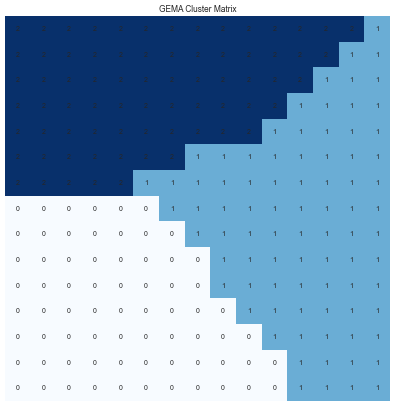

In [74]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.set_aspect('equal')

ax.imshow(gema_cluster_labels, cmap='Blues')

for i in range(gema_cluster_labels.shape[0]):
    for j in range(gema_cluster_labels.shape[1]):
        ax.text(j, i, gema_cluster_labels[i,j], ha="center", va="center")
        
ax.margins(.05)
ax.axis("off")

plt.title("GEMA Cluster Matrix")

plt.show()

#### Component Planes

In [75]:
# Commented out because it uses too much space
# GEMA.Visualization.codebook_vectors(gema_model, headers=np.array(dataset.feature_names))

#### Evaluate

In [76]:
gema_labels = [gema_cluster_labels[gema_model.calculate_bmu(d[0])[1]] for d in df[feats].values]
#gema_labels


In [77]:
print('Homogeneity: ', np.round(homogeneity_score(df.target, gema_labels),5))
print('Completeness:', np.round(completeness_score(df.target, gema_labels),5))
print('V Measure:   ', np.round(v_measure_score(df.target, gema_labels),5))


Homogeneity:  0.30515
Completeness: 0.36171
V Measure:    0.33103


#### Comments

- Inputs:
    - `numpy` array?
- Outputs:
    - UMatrix
    - Hits Map: manually constructed
    - Clustering: manually constructed
    - Weights matrix: `gema_model.weights`
- Parameters:
    - topology type: rectangular
    - grid type: square
    - number of epochs
    - initialization
- Utility:
    - BMU finder
    - Visualizations
        - UMatrix
        - Hits Map
        - Component Planes

- Last GitHub update 
    - July 2022

### SOM Package

Source: 

GitHub Stars: 

Last update: 

#### Train

#### Visualize

#### Visualize UMatrix

#### Visualize Hits

#### Visualize Clusters

#### Evaluate

#### Comments

- Inputs:
    - `numpy` array?
    - `pandas` dataframe?
    - native Python list of lists?
- Outputs:
    - UMatrix
    - Hits Map
    - Clustering
    - Weights matrix
- Parameters:
    - topology type: rectangular; ring; etc
    - grid type: square; hexagonal
    - number of epochs
    - initialization
- Utility:
    - BMU finder
    - Visualizations
        - UMatrix
        - Hits Map
- Last GitHub update   

# END